In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn import tree
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#pickle read in
df_LA_geo = pd.read_pickle("../data/LA_geo.pickle")
df_LA = pd.read_pickle("../data/LA.pickle")
df_LA_stations = pd.read_pickle("../data/LA_stations.pickle")
df_LA_weather = pd.read_csv("../data/weather.csv")

In [3]:
weather=pd.read_csv('../data/weather.csv')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.set_index("date_time", inplace=True)
weather.head()

,max_temp,min_temp,precip
date_time,,,
2018-01-01 00:00:00,14.4,14.150,0.0
2018-01-01 01:00:00,14.4,14.275,0.0
2018-01-01 02:00:00,14.4,14.400,0.0
2018-01-01 03:00:00,14.4,14.400,0.0
2018-01-01 04:00:00,14.4,13.900,0.0


In [4]:
df_la=pd.read_csv('../data/LA.csv')
df_la["start_time"] = pd.to_datetime(df_la['start_time'])
df_la["end_time"] = pd.to_datetime(df_la['end_time'] ) 
df_la["trip_duration"] = pd.to_timedelta(df_la.trip_duration)
df_la.set_index("start_time", inplace=True)
df_la.head(2)

,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_duration,trip_duration_in_hours
start_time,,,,,,,,,
2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,Pershing Square,Grand & Olympic,0 days 00:21:00,0.350000
2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,Pershing Square,Grand & Olympic,0 days 00:20:00,0.333333


In [5]:
# calc demand
df = weather.copy()
df["demand"] = df_la.bike_id.resample("H").count()
df.head(2)

,max_temp,min_temp,precip,demand
date_time,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25
2018-01-01 01:00:00,14.4,14.275,0.0,24


In [6]:
# time, date features
df["season"] = df.index.month%12 // 3 + 1 
dummies = pd.get_dummies(df["season"]).rename(columns=lambda x: "season_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["season"], inplace=True, axis=1)

df["day_of_week"] = df.index.day_of_week
df["weekend"] = df.day_of_week.apply(lambda x: 1 if x >=4 else 0) #friday till sunday
df.drop("day_of_week", inplace=True, axis=1)

df["hour"] = df.index.hour 
df["time_of_day"] = df.hour.apply(lambda x: (x-1)//6 if x>0 else 3)
dummies = pd.get_dummies(df["time_of_day"]).rename(columns=lambda x: "time_of_day_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["time_of_day"], inplace=True, axis=1)
df.drop(["hour"], inplace=True, axis=1)

df.head(2)

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
date_time,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,1,0,0,0


In [7]:
# lag features
df["lag_2"] = df.demand.shift(2) # demand in last hour before the prediction takes place
df["lag_3"] = df.demand.shift(3) # demand in last hour before the prediction takes place
df["lag_4"] = df.demand.shift(4) # demand in last hour before the prediction takes place
df.dropna(inplace=True)
df.head(2)

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,lag_2,lag_3,lag_4
date_time,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,0,0,0,12.0,24.0,25.0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,0,0,0,3.0,12.0,24.0


In [8]:
#special days
#one hour before to one after 
df['event'] = 0
df.loc['2018-09-30 07:00:00':'2018-09-30 16:00:00','event'] = 1
df.loc['2018-12-02 08:00:00':'2018-12-02 16:00:00','event'] = 1
df.head(2)

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,lag_2,lag_3,lag_4,event
date_time,,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,0,0,0,12.0,24.0,25.0,0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,0,0,0,3.0,12.0,24.0,0


In [9]:
df["weekend_x_lag_2"] = df.weekend * df.lag_2
df["weekend_x_lag_3"] = df.weekend * df.lag_3
df["weekend_x_lag_4"] = df.weekend * df.lag_4

df["diff_lag_2_lag_3"] = df.lag_2 - df.lag_3
df["diff_lag_3_lag_4"] = df.lag_3 - df.lag_4
df.head(2)

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,...,time_of_day_3,lag_2,lag_3,lag_4,event,weekend_x_lag_2,weekend_x_lag_3,weekend_x_lag_4,diff_lag_2_lag_3,diff_lag_3_lag_4
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 04:00:00,14.4,13.9,0.0,4,1,0,0,0,0,1,...,0,12.0,24.0,25.0,0,0.0,0.0,0.0,-12.0,-1.0
2018-01-01 05:00:00,13.9,13.9,0.0,7,1,0,0,0,0,1,...,0,3.0,12.0,24.0,0,0.0,0.0,0.0,-9.0,-12.0


<AxesSubplot:>

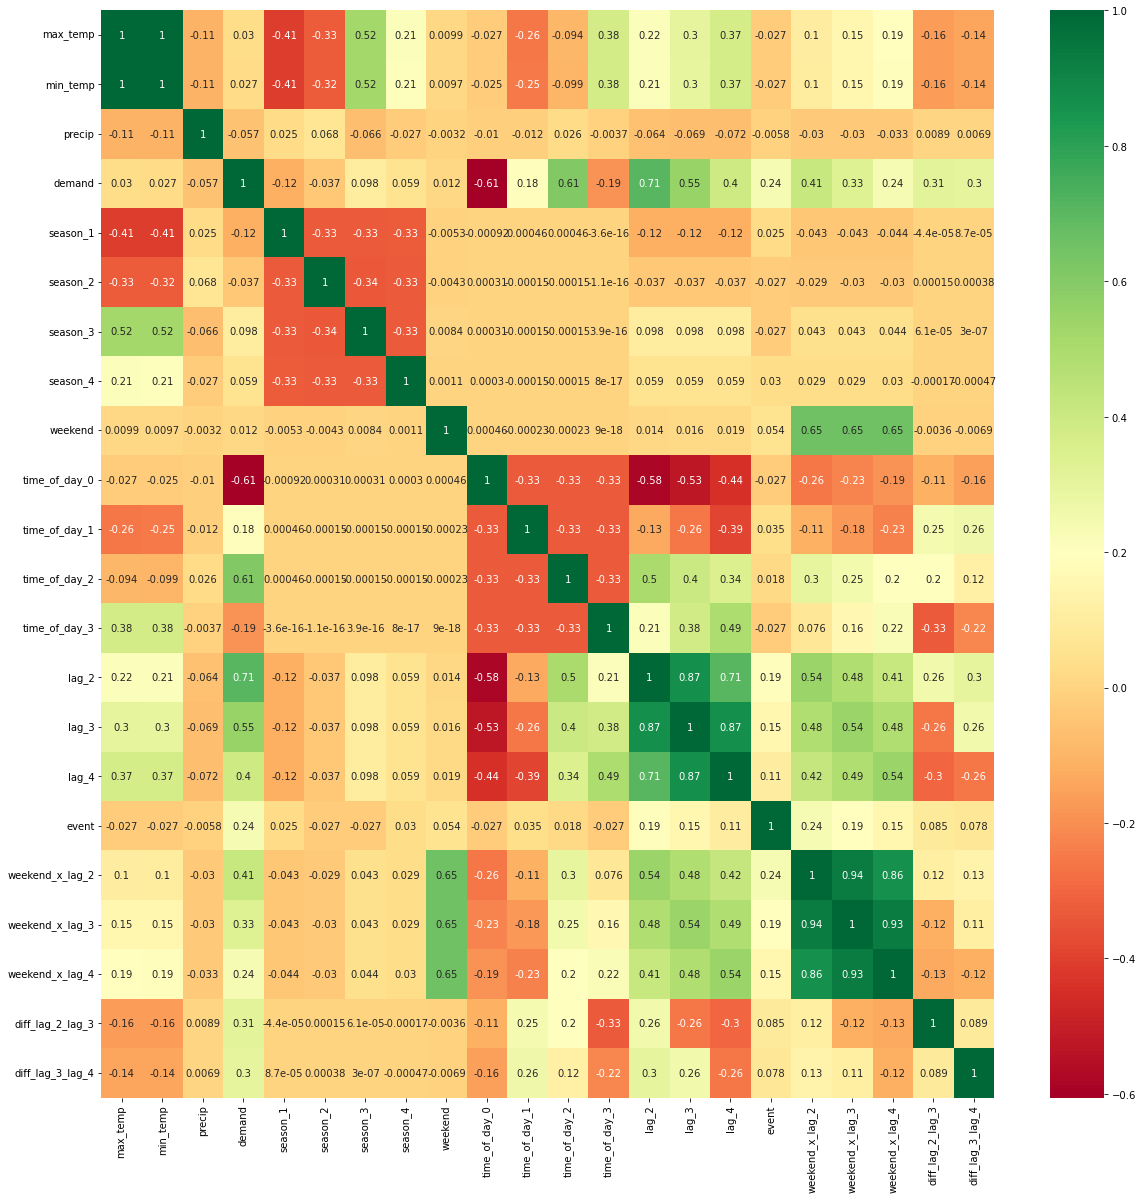

In [10]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Polynomial Regression all Features

In [11]:
#scale
X = df.drop(["demand"],axis=1).copy()
y = df.demand

In [12]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_train)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)
X_scaled_df.head(2)

,max_temp,min_temp,precip,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,...,time_of_day_3,lag_2,lag_3,lag_4,event,weekend_x_lag_2,weekend_x_lag_3,weekend_x_lag_4,diff_lag_2_lag_3,diff_lag_3_lag_4
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-03 01:00:00,-0.485010,-0.474020,-0.122078,1.766839,-0.578292,-0.585829,-0.579297,-0.869864,1.746680,-0.576534,...,-0.574022,-1.005347,-0.491789,-0.661885,-0.042403,-0.569244,-0.570414,-0.568046,-0.986462,0.335091
2018-03-02 08:00:00,-1.172908,-1.160531,-0.122078,-0.565982,1.729229,-0.585829,-0.579297,1.149605,-0.572515,1.734503,...,-0.574022,-0.936604,-1.076339,-1.106319,-0.042403,-0.272459,-0.422698,-0.458392,0.267448,0.070105


In [15]:
def create_polynomial_regression_model(degree):
    #"Creates a polynomial regression model for the given degree"

    poly_features = PolynomialFeatures(degree=degree)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)
    
    # compute errors
    rsme_err_train.append(rmse_train)
    rsme_err_cv.append(rmse_test)
    
    # compute errors
    r2_err_train.append(r2_train)
    r2_err_cv.append(r2_test)

#     print("The model performance for the training set")  
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")

#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))
    
    return rsme_err_train, rsme_err_cv, r2_err_train, r2_err_cv

In [16]:
rsme_err_train = []
rsme_err_cv = []
r2_err_train  = []
r2_err_cv = []
deg = []
degree = 4
for i in range(1,degree,1):    
    result  =  create_polynomial_regression_model(i)
#     print('--RSME Train Error---', result[0])
#     print('--RSME Validation Error---', result[1])
#     print('--R2 Train Error---', result[2])
#     print('--R2 Validation Error---', result[3])
    rsme_train = result[0]
    rsme_val = result[1]
    r2_train = result[2]
    r2_val = result[3]
    deg.append(i)

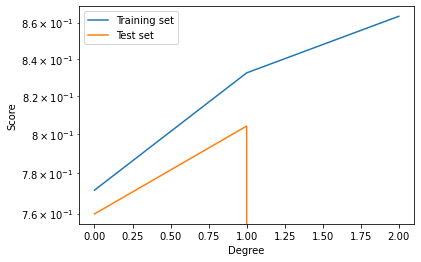

In [22]:
#plot the R2 error
plt.semilogy(range(degree-1), r2_train, range(degree-1), r2_val)
plt.xlabel("Degree")
plt.ylabel("Score")
plt.legend(['Training set', 'Test set'])

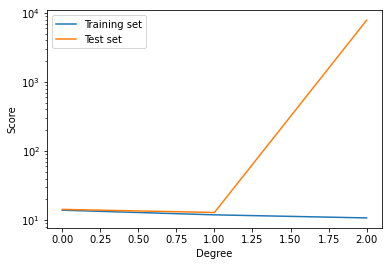

In [19]:
#plot the RSME error
plt.semilogy(range(degree-1), rsme_train, range(degree-1), rsme_val)
plt.xlabel("Degree")
plt.ylabel("Score")
plt.legend(['Training set', 'Test set'])

## Polynomial Regression

Define train and test datasets

In [13]:
xa = df["max_temp"]
ya = df.demand
# train-test split
X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3,random_state=42 )
#X_train_2, X_val, y_train_2, y_val = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

### Find a good model degree

Train a model for degrees ranging from 0-50 on the training dataset and plot the errors.

Text(0, 0.5, 'Mean squared error')

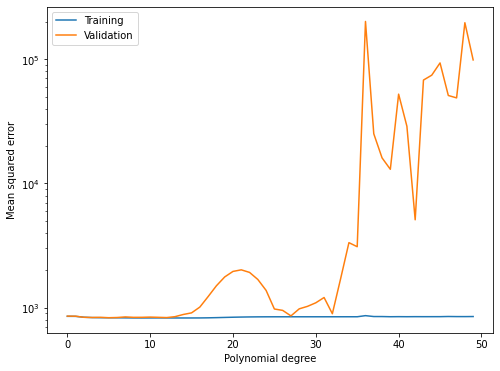

In [15]:
err_train = []
err_cv = []

# define loop
for deg in range(50): # we want to loop across 0-50 degrees
    # create poly features
    poly_feat = PolynomialFeatures(degree = deg)
    X_train_poly = poly_feat.fit_transform(X_train.values.reshape(-1,1))
    X_test_poly = poly_feat.fit_transform(X_test.values.reshape(-1,1))
    
    # fit model
    lin_mod_poly = LinearRegression()
    lin_mod_poly.fit(X_train_poly,y_train)
    
    # compute errors
    err_train.append(mean_squared_error(lin_mod_poly.predict(X_train_poly),y_train))
    err_cv.append(mean_squared_error(lin_mod_poly.predict(X_test_poly),y_test))
    
plt.figure(figsize = (8,6))
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

#print('Minimal MSE: ', min(err_cv))

### Plot the Polnomial Regression with degree = 13

Use the knowledge from above to train the model using the optimal degree.

In [16]:
def plot_Poly_regression(X,Y,d):
    
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.values.reshape(-1,1))
    
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("MAX Temperature (°C)")
    plt.ylabel("Demand rentals (per hour)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.029152494489293468


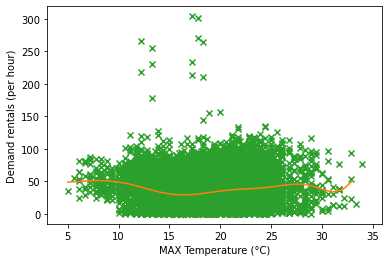

In [18]:
plot_Poly_regression(X = xa, Y = ya, d = 13)

### Polynomial modeling function for normalized data:

In [19]:
xa = df["max_temp"]
ya = df.demand
# train-test split
X_train, X_test, y_train, y_test = train_test_split(xa, ya, test_size=0.3,random_state=42 )

C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline

C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline

C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline

C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline

Text(0, 0.5, 'R2 score')

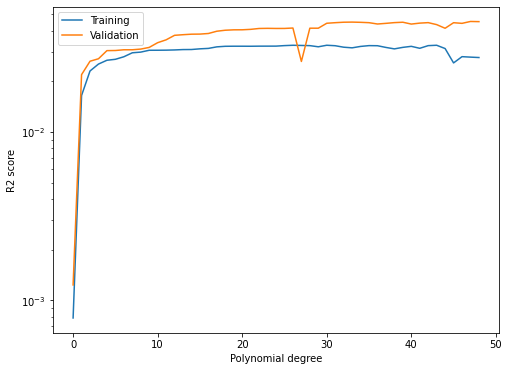

In [20]:
err_train = []
err_cv = []
for i in range(1,50,1):
   
    # Polynomial model:
    poly_reg = PolynomialFeatures (degree = i)
    x_train_poly = poly_reg.fit_transform(X_train.values.reshape(-1,1))
    x_test_poly = poly_reg.fit_transform(X_test.values.reshape(-1,1))
    
    #Normalizing features (train):
    lin_reg_2 = LinearRegression(normalize = True)
    lin_reg_2.fit(x_train_poly, y_train)
    model_pred_train = lin_reg_2.predict(x_train_poly)
        
    #Normalizing features (test):
    lin_reg_3 = LinearRegression(normalize = True)
    lin_reg_3.fit(x_test_poly, y_test)
    model_pred_test = lin_reg_3.predict(x_test_poly)
    
    x_fit_train = np.arange(X_train.min(),X_train.max() ,1)[:, np.newaxis]
    y_pred_train = lin_reg_2.predict(poly_reg.fit_transform(x_fit_train.reshape(-1,1)))
    
    x_fit_test = np.arange(X_test.min(),X_test.max() ,1)[:, np.newaxis]
    y_pred_test = lin_reg_3.predict(poly_reg.fit_transform(x_fit_test.reshape(-1,1)))
    
#     print ('The R^2 for quadratic curve is: ',r2_score(y_train, model_pred_train))
#     print ('The R^2 for quadratic curve is: ',r2_score(y_test, model_pred_test))
#     plt.scatter(X,Y,marker="x", c='C2')
#     ylim = plt.ylim()
#     plt.plot(x_fit,y_pred, c='C1')
#     plt.xlabel("Temperature (°C)")
#     plt.ylabel("Demand (GW)")
#     plt.xlim([X.min()-2,X.max()+2])
#     plt.ylim(ylim)
    
    # compute errors
    err_train.append(r2_score(y_train, model_pred_train))
    err_cv.append(r2_score(y_test, model_pred_test))
    
plt.figure(figsize = (8,6))
plt.semilogy(range(49), err_train, range(49), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("R2 score")

In [21]:
def plot_regression_poly_norm(X,Y,d):
    
    
    # Polynomial model:
    poly_reg = PolynomialFeatures (degree = d)
    x_poly = poly_reg.fit_transform(X.values.reshape(-1,1))
    
    #Normalizing features:
    lin_reg_2 = LinearRegression(normalize = True)
    lin_reg_2.fit(x_poly, Y)
    model_pred = lin_reg_2.predict(x_poly)
    
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_2.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2])
    plt.ylim(ylim)
    print ('The R^2 for the curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_2.coef_)


The R^2 for the curve is:  0.030566021986992098


C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


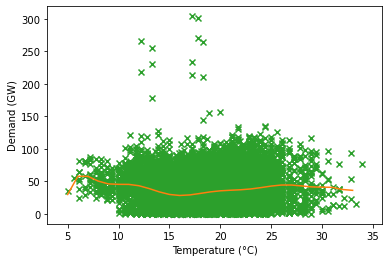

In [22]:
plot_regression_poly_norm(X = xa,Y = ya ,d = 12)

### Regularization using Scikit-learn

#### Ridge regression ($L_2$ Regularization)

In [23]:
from sklearn.linear_model import Ridge

Poly = PolynomialFeatures(degree = 100)
X_poly = Poly.fit_transform(xa.values.reshape(-1,1))

model_L2 = Ridge(alpha = 1, normalize = True, solver = 'lsqr')

model_L2.fit(X_poly, ya)
prediction = model_L2.predict(X_poly)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for quadratic curve is: ',r2_score(ya, prediction))

The R^2 for quadratic curve is:  0.007193908416340822


C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


#### Lasso regression ($L_1$ regularization)

In [24]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.1)

model_L1.fit(X_poly, ya)
predict = model_L1.predict(X_poly)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

print ('The R^2 for quadratic curve is: ',r2_score(ya, predict))

The R^2 for quadratic curve is:  0.025815816220735477


C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.650e+06, tolerance: 7.481e+02
  model = cd_fast.enet_coordinate_descent(
